# Classifying gas and electricity usage

Each year, the Centraal Bureau voor de Statistiek(CBS) or Statistics Netherlands collects demographic statistics at the gemeente (town), wijk (district) and buurt (neighbourhood) levels. The data that was used for the analysis is from the year 2016.

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#reading data
data = pd.read_csv('kwb_test.csv')

PRINT_SCORES = False

# Data Preprocessing

In [43]:
from sklearn.model_selection import train_test_split

#filtering on columns
data = data[data['recs'] == 'Buurt']
data = data[(data['g_ele'] != '.') & (data['g_gas'] != '.')]
data = data.drop(columns=['gwb_code','gwb_code_10' ,'gwb_code_8', 'regio', 'gm_naam', 'recs', 'ind_wbi'])

#replace all dots with NaN
data = data.replace('.', np.nan)

#split target variables (g ele, g gas)
X = data.drop(columns=['g_ele', 'g_gas'])

y = pd.DataFrame(data=[])

y['electricity'] = pd.qcut(data['g_ele'], 4, labels=False)
y['gas'] = pd.qcut(data['g_gas'], 4, labels=False)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

## Feature Imputation:

SimpleImputer: has different imputation methods, namely: 'mean', 'median' & 'most_frequent'  
IterativeImputer: different more elaborate impurtation methods like KNN
Mainly the SimpleImputer will be used, since for this data the difference in impact on model performance between the two models is negligible.<br>

## Feature Scaling

There are two different scaling techniques that will be used in this assignment: StandardScaler or MinMaxScaler.<br>
StandardScaler: mean is set to zero, and variance is set to unit (1).<br>
MinMaxScaler: On a scale from 0 to 1, where 0 is the min value and 1 is the maximum.<br>

# Classification

In [44]:
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

## Linear SVC - Default model

In [94]:
#pipelines for default svc without scaling 
pipe_svc_gas = make_pipeline(SimpleImputer(), LinearSVC(random_state=0))
pipe_svc_elec = make_pipeline(SimpleImputer(), LinearSVC(random_state=0))

pipe_svc_gas.fit(X_train, y_train['gas'])
pipe_svc_elec.fit(X_train, y_train['electricity'])

#pipelines for default svc with standard scaling
pipe_svc_gas_ss = make_pipeline(StandardScaler(), SimpleImputer(), LinearSVC(random_state=0))
pipe_svc_elec_ss = make_pipeline(StandardScaler(), SimpleImputer(), LinearSVC(random_state=0))

pipe_svc_gas_ss.fit(X_train, y_train['gas'])
pipe_svc_elec_ss.fit(X_train, y_train['electricity'])

#pipelines for default svc with minmax scaling
pipe_svc_gas_mm = make_pipeline(MinMaxScaler(), SimpleImputer(), LinearSVC(random_state=0))
pipe_svc_elec_mm = make_pipeline(MinMaxScaler(), SimpleImputer(), LinearSVC(random_state=0))

pipe_svc_gas_mm.fit(X_train, y_train['gas'])
pipe_svc_elec_mm.fit(X_train, y_train['electricity'])

#report scores
if PRINT_SCORES:
    print('Linear SVC classification report for unscaled prediction (gas): \n')
    print(classification_report(pipe_svc_gas.predict(X_test), y_test['gas']))
    print('Linear SVC classification report for unscaled prediction (electricity): \n')
    print(classification_report(pipe_svc_elec.predict(X_test), y_test['electricity']))
    print('Linear SVC classification report for standard scaled prediction (gas): \n')
    print(classification_report(pipe_svc_gas_ss.predict(X_test), y_test['gas']))
    print('Linear SVC classification report for standard scaled prediction (electricity): \n')
    print(classification_report(pipe_svc_elec_ss.predict(X_test), y_test['electricity']))
    print('Linear SVC classification report for minmax scaled prediction (gas): \n')
    print(classification_report(pipe_svc_gas_mm.predict(X_test), y_test['gas']))
    print('Linear SVC classification report for minmax scaled prediction (electricity): \n')
    print(classification_report(pipe_svc_elec_mm.predict(X_test), y_test['electricity']))

/Users/sebastiaanvergunst/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/sebastiaanvergunst/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/sebastiaanvergunst/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/sebastiaanvergunst/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [102]:
# pipe_svc_gas_ss.get_params()

### Results

|SVC - gas| f1-score (macro) | accuracy |
| --- | --- | --- |
|unscaled | 0.43 | 0.46 |
|standard scaled| 0.60 | 0.60 |
|minmax scaled| 0.58 | 0.59 |

|SVC - electricity| f1-score (macro) | accuracy |
| --- | --- | --- |
|unscaled| 0.49 | 0.57 |
|standard scaled| 0.68 | 0.69 |
|minmax scaled | 0.67 | 0.68 |

### Effects of data preprocessing on the classification performance

Linear SVC performs very bad on unscaled data, since it is not able to converge. This explains the difference in class support. Both the standard scaler and the minmax scaler improve the model performance. This has something to do with the fact that if the data is scaled, the model is better able to find a decision boundary.

### StandardScaler VS MinMaxScaler
Since the StandardScaler and the MinMaxScaler yield similair results we will continue using only one scaling strategy from now on. We chose to go with the StandardScaler, since it performs slightly better than the MinMaxScaler.

## LogisticRegression

In [ ]:
#setup pipeline - includes scaler and imputer
pipe_lr = make_pipeline(SimpleImputer(), LogisticRegression(random_state=0,penalty="l1"))
pipe_lr_ss = make_pipeline(StandardScaler(), SimpleImputer(), LogisticRegression(random_state=0, penalty="l1"))

#parameters
param_grid_lr = {'logisticregression__C': np.linspace(300, 1000, num=5)}

#grids
grid_lr_elec_nonscaled = GridSearchCV(pipe_lr, param_grid_lr, cv=3)
grid_lr_gas_nonscaled = GridSearchCV(pipe_lr, param_grid_lr, cv=3)
grid_lr_elec_ss = GridSearchCV(pipe_lr_ss, param_grid_lr, cv=3)
grid_lr_gas_ss = GridSearchCV(pipe_lr_ss, param_grid_lr, cv=3)

#fitting the data
grid_lr_elec_nonscaled.fit(X_train, y_train['electricity'])
grid_lr_gas_nonscaled.fit(X_train, y_train['gas'])
grid_lr_elec_ss.fit(X_train, y_train['electricity'])
grid_lr_gas_ss.fit(X_train, y_train['gas'])

#report scores
if PRINT_SCORES:
    print('LogisticRegression classification report for unscaled prediction (gas): \n')
    print(classification_report(grid_lr_gas_nonscaled.predict(X_test), y_test['gas']))
    print('LogisticRegression classification report for unscaled prediction (electricity): \n')
    print(classification_report(grid_lr_elec_nonscaled.predict(X_test), y_test['electricity']))
    print('LogisticRegression classification report for standard scaled prediction (gas): \n')
    print(classification_report(grid_lr_gas_ss.predict(X_test), y_test['gas']))
    print('LogisticRegression classification report for standard scaled prediction (electricity): \n')
    print(classification_report(grid_lr_elec_ss.predict(X_test), y_test['electricity']))

/Users/sebastiaanvergunst/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/sebastiaanvergunst/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/Users/sebastiaanvergunst/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/sebastiaanvergunst/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/sebastiaanvergunst/anaconda3/lib/python3.6/site-pack

/Users/sebastiaanvergunst/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/sebastiaanvergunst/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/sebastiaanvergunst/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/Users/sebastiaanvergunst/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/sebastiaanvergunst/anaconda3/lib/python3.6/site-packag

/Users/sebastiaanvergunst/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/sebastiaanvergunst/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/sebastiaanvergunst/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/Users/sebastiaanvergunst/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/sebastiaanvergunst/anaconda3/lib/python3.6/site-packag

### Results:

|Logistic Regression - gas| f1-score (macro) | accuracy |C|
| --- | --- | --- |---|
|unscaled | 0.60 | 0.60 | 825 |
|standard scaled| 0.60 | 0.60 | 825 | 

|Logistic Regression - electricity| f1-score (macro) | accuracy |C|
| --- | --- | --- |---|
|unscaled| 0.70 | 0.70 | 650 |
|standard scaled| 0.70 | 0.70 | 300 |


### Testing impact of C

/Users/sebastiaanvergunst/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/sebastiaanvergunst/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


C = 1
Training set score: 0.605
Test set score: 0.602



/Users/sebastiaanvergunst/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/sebastiaanvergunst/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


C = 1000
Training set score: 0.607
Test set score: 0.603



/Users/sebastiaanvergunst/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/sebastiaanvergunst/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


C = .00001
Training set score: 0.474
Test set score: 0.469



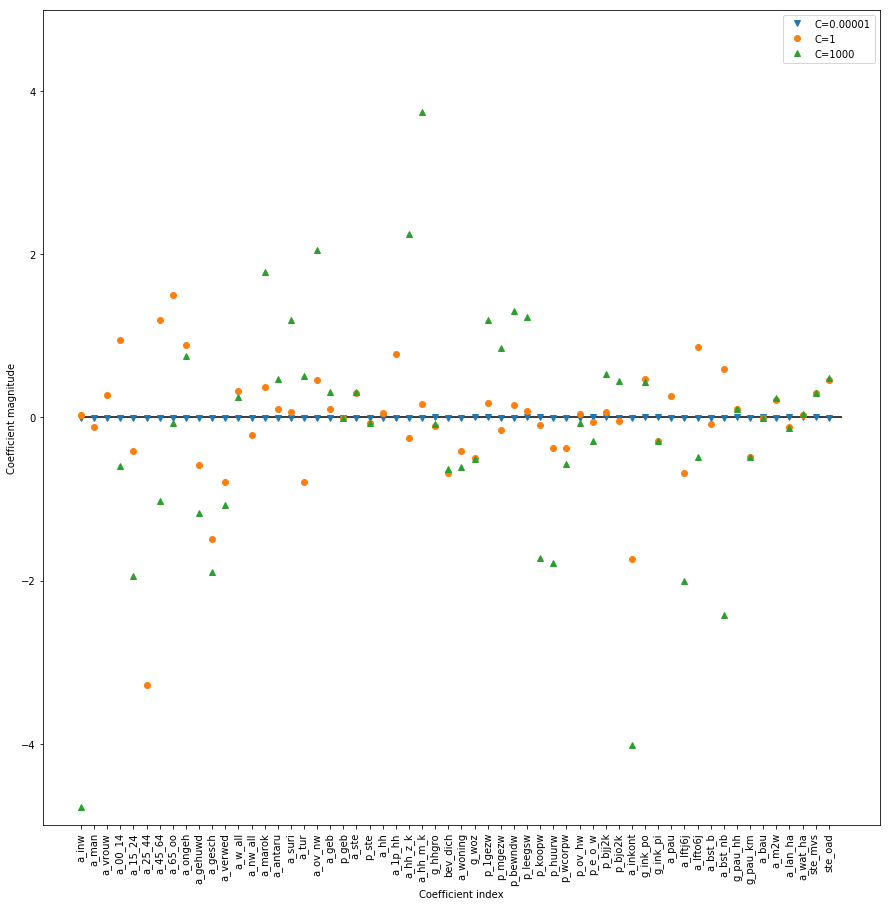

In [86]:
#plotting feature importance for different values of C
#LinearLogistic
logreg = make_pipeline(StandardScaler(), SimpleImputer(), LogisticRegression(random_state=0, C=1))
logreg.fit(X_train, y_train['gas'])
print("C = 1")
print("Training set score: {:.3f}".format(logreg.score(X_train,  y_train['gas']))) 
print("Test set score: {:.3f}\n".format(logreg.score(X_test, y_test['gas'])))

logreg100 = make_pipeline(StandardScaler(), SimpleImputer(), LogisticRegression(random_state=0, C=1000))
logreg100.fit(X_train, y_train['gas'])
print("C = 1000")
print("Training set score: {:.3f}".format(logreg100.score(X_train,  y_train['gas']))) 
print("Test set score: {:.3f}\n".format(logreg100.score(X_test, y_test['gas'])))

logreg001 = make_pipeline(StandardScaler(), SimpleImputer(), LogisticRegression(random_state=0, C=0.00001))
logreg001.fit(X_train, y_train['gas'])
print("C = .00001")
print("Training set score: {:.3f}".format(logreg001.score(X_train,  y_train['gas']))) 
print("Test set score: {:.3f}\n".format(logreg001.score(X_test, y_test['gas'])))

fig= plt.figure(figsize=(15,15))
plt.plot(logreg001['logisticregression'].coef_.T[:,2], 'v', label="C=0.00001")
plt.plot(logreg['logisticregression'].coef_.T[:,2], 'o', label="C=1")
plt.plot(logreg100['logisticregression'].coef_.T[:,2], '^', label="C=1000")
plt.xticks(range(X_train.shape[1]), X_train.columns, rotation=90)
plt.hlines(0, 0, X_train.shape[1])
plt.ylim(-5, 5)
plt.xlabel("Coefficient index")
plt.ylabel("Coefficient magnitude")
plt.legend()
plt.show()

/Users/sebastiaanvergunst/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/sebastiaanvergunst/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/Users/sebastiaanvergunst/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/sebastiaanvergunst/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/sebastiaanvergunst/anaconda3/lib/python3.6/site-pack

/Users/sebastiaanvergunst/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/sebastiaanvergunst/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/sebastiaanvergunst/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/Users/sebastiaanvergunst/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/sebastiaanvergunst/anaconda3/lib/python3.6/site-packag

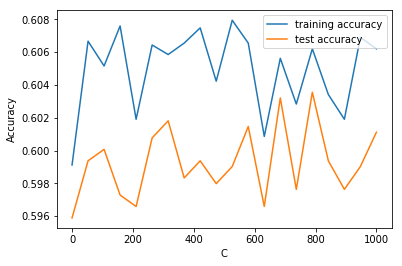

In [9]:
#plotting scores for different values of C
training_accuracy = [] 
test_accuracy = []
# try C from 0.00001 to 1000
C_settings = np.linspace(0.0001, 1000, 20)
for C_n in C_settings:
    # build the model
    pipe_lr = make_pipeline(SimpleImputer(), LogisticRegression(random_state=0, C=C_n))
    pipe_lr.fit(X_train, y_train['gas'])
    # record training set accuracy 
    training_accuracy.append(pipe_lr.score(X_train, y_train['gas'])) 
    # record generalization accuracy 
    test_accuracy.append(pipe_lr.score(X_test, y_test['gas']))

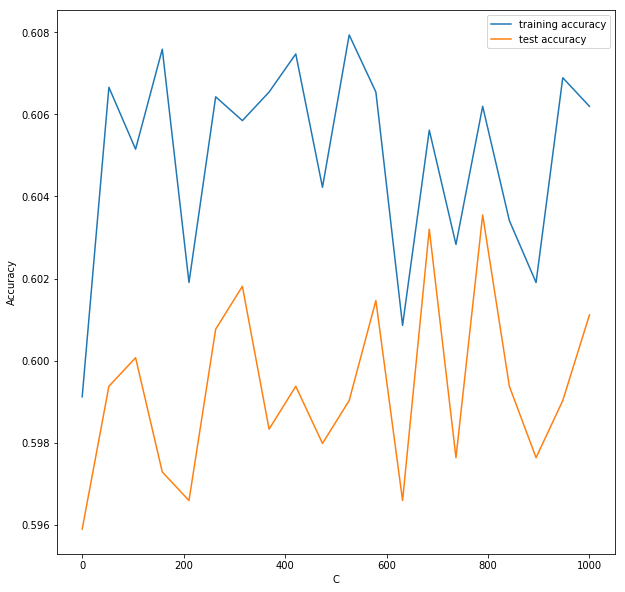

In [112]:
fig= plt.figure(figsize=(10,10))
plt.plot(C_settings, training_accuracy, label="training accuracy")
plt.plot(C_settings, test_accuracy, label="test accuracy")
plt.ylabel("Accuracy")
plt.xlabel("C")
plt.legend()
plt.show()

### Effects of C and data scaling on the classification performance

By default LinearRegression uses L2 regularization.

If C is small there will be strong regularization and when C is very big regularization tends to dissapear. As seen in the plot above.

Regularization doesn't seem to impact model performance as seen in the plot. When ranged from 0.0001 to 1000 it can be seen that the accuracy fluctuates between 0.596 and 0.608. 

Scaling the data for Logistic Regression does not affect model performance, since the coefficient of the predictor variables with a large range that do not affect the target will be made small so that they will not affect the prediction.

# Trees

In [40]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

## Decision Tree

In [108]:
#setting up pipelines
dt_pipeline_gas = make_pipeline(SimpleImputer(), DecisionTreeClassifier(random_state=0))
dt_pipeline_elec = make_pipeline(SimpleImputer(), DecisionTreeClassifier(random_state=0))
dt_pipeline_scaled_gas = make_pipeline(StandardScaler(), SimpleImputer(), DecisionTreeClassifier(random_state=0))
dt_pipeline_scaled_elec = make_pipeline(StandardScaler(), SimpleImputer(), DecisionTreeClassifier(random_state=0))

#fitting data
dt_pipeline_gas.fit(X_train, y_train['gas'])
dt_pipeline_elec.fit(X_train, y_train['electricity'])
dt_pipeline_scaled_gas.fit(X_train, y_train['gas'])
dt_pipeline_scaled_elec.fit(X_train, y_train['electricity'])

#reporting scores
if PRINT_SCORES:
    print('classification report for unscaled prediction (gas): \n')
    print(classification_report(dt_pipeline_gas.predict(X_test), y_test['gas']))
    print('classification report for unscaled prediction (electricity): \n')
    print(classification_report(dt_pipeline_elec.predict(X_test), y_test['electricity']))
    print('classification report for standard scaled prediction (gas): \n')
    print(classification_report(dt_pipeline_scaled_gas.predict(X_test), y_test['gas']))
    print('classification report for standard scaled prediction (electricity): \n')
    print(classification_report(dt_pipeline_scaled_elec.predict(X_test), y_test['electricity']))

### Scores

|DecisionTreeClassifier - gas| f1-score (macro) | accuracy |
| --- | --- | --- |
|unscaled | 0.54 | 0.54 |
|standard scaled | 0.54 | 0.54 |

|DecisionTreeClassifier - electricity| f1-score (macro) | accuracy |
| --- | --- | --- |
|unscaled | 0.63 | 0.63 |
|standard scaled | 0.63 | 0.63 |

#### Preproccesing impact on model performance

Scaling doesn't affect model performance as can be seen from the results.

#### Decision trees and overfitting
Decision trees are easliy overfitted, because the model will run untill all leafes are pure. This means that the model is fitting the data perfectly -> overfitting. Normally if we want to reduce overfitting in decision trees we would need to do some pruning -> setting parameters. We can specify a max depth or a number of leaves to make sure the tree doens't grow to an overfit.

### grid search

The grid search is only performed on the unscaled pipelines, since there is no difference between scaled and unscaled.

In [79]:
#parameters
param_grid_dt = {'decisiontreeclassifier__max_depth': [4,8,15], 
              'decisiontreeclassifier__max_features':[3,6,9],
              'decisiontreeclassifier__min_samples_leaf':[1,2,3],
              'decisiontreeclassifier__min_samples_split':[2]}

#grid search
grid_gas = GridSearchCV(dt_pipeline_gas, param_grid_dt, cv=3).fit(X_train, y_train['gas'])
grid_elec = GridSearchCV(dt_pipeline_elec, param_grid_dt, cv=3).fit(X_train, y_train['electricity'])

In [80]:
print(classification_report(grid_elec.predict(X_test), y_test['electricity']))
print(classification_report(grid_gas.predict(X_test), y_test['gas']))

              precision    recall  f1-score   support

           0       0.74      0.81      0.77       637
           1       0.60      0.56      0.58       753
           2       0.49      0.55      0.52       665
           3       0.79      0.69      0.73       818

    accuracy                           0.65      2873
   macro avg       0.65      0.66      0.65      2873
weighted avg       0.66      0.65      0.65      2873

              precision    recall  f1-score   support

           0       0.72      0.61      0.66       866
           1       0.53      0.57      0.55       659
           2       0.50      0.53      0.51       669
           3       0.52      0.55      0.53       679

    accuracy                           0.57      2873
   macro avg       0.57      0.56      0.56      2873
weighted avg       0.58      0.57      0.57      2873



In [87]:
# grid_gas.best_estimator_.get_params()
# grid_elec.best_estimator_.get_params()

### Scores - grid search

|DecisionTreeClassifier - gas| f1-score (macro) | accuracy |
| --- | --- | --- |
|unscaled | 0.56 | 0.57 |

|DecisionTreeClassifier - electricity| f1-score (macro) | accuracy |
| --- | --- | --- |
|unscaled| 0.65 | 0.65 |

### Feature importance

Feature importances for gas model:


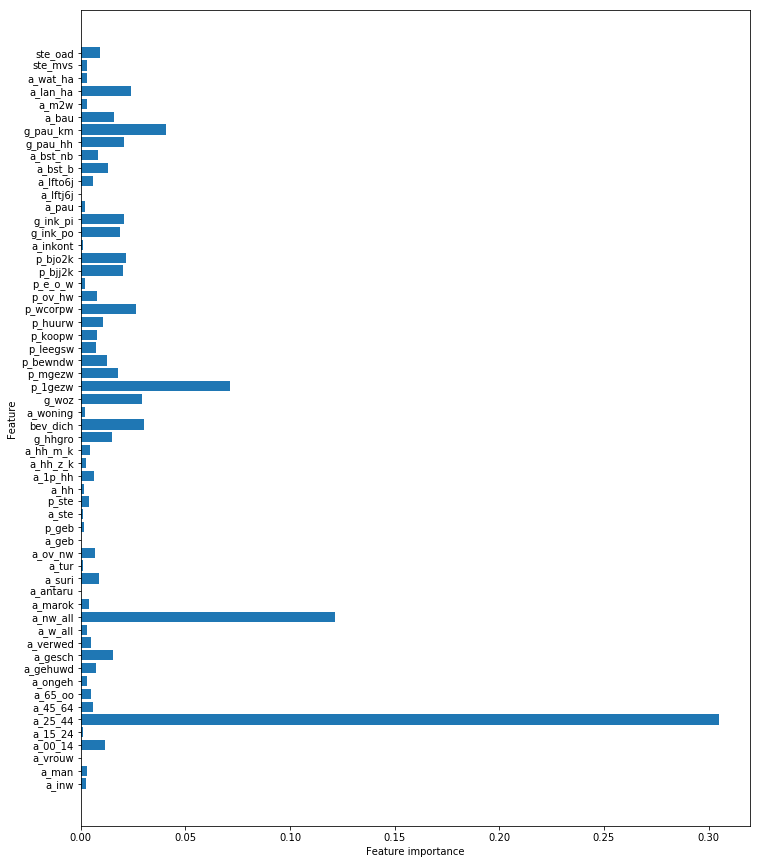

Feature importances for electricity model:


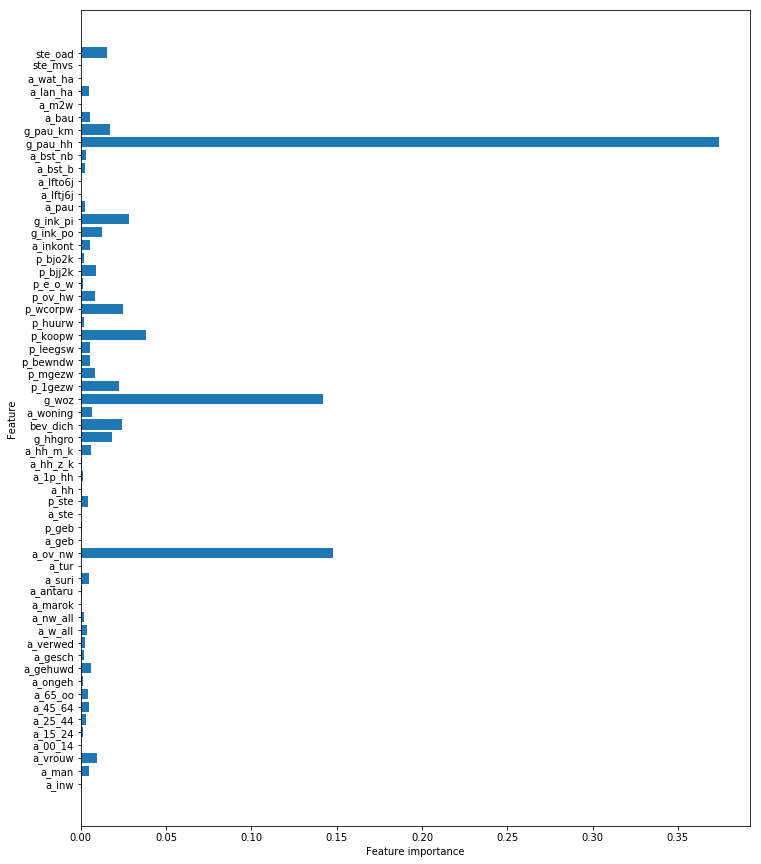

In [84]:
def plot_feature_importances(model):
    n_features = X_train.shape[1]
    fig= plt.figure(figsize=(12,15))
    plt.barh(range(n_features), model['decisiontreeclassifier'].feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), X_train.columns) 
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    plt.show()
    
print("Feature importances for gas model:")
plot_feature_importances(grid_gas.best_estimator_)

print("Feature importances for electricity model:")
plot_feature_importances(grid_elec.best_estimator_)

When looking at feature importance for the trees, it can be seen that they have 2/3 features that are most important.

For the gas model:
- a_nw_all: number of non-western inhabitants.
- a_25_44: number of inhabitants between 25 and 44 years of age.

For the electricity model:
- g_pau_hh: number of passenger card per household
- g_woz: average property value
- a_ov_nw: number of non-western inhabitants excluding inhabitants from Marokko, (voormalige) Nederlandse Antillen and Aruba, Suriname and Turkije.

These results are quite interesting. The only feature that would make sense is the average property value, since a more expensive house is probably a bigger house which needs more electricity. It's also interesting that non-western inhabitants are important in the tree. Maybe non-western inhabitants have a different culture and therefore use their electricity/gas in other ways. These are interesting things to further look into.


## Random Forest

In [101]:
#setting up pipelines
rf_pipeline_gas = make_pipeline(SimpleImputer(), RandomForestClassifier(random_state=0))
rf_pipeline_elec = make_pipeline(SimpleImputer(), RandomForestClassifier(random_state=0))
rf_pipeline_scaled_gas = make_pipeline(StandardScaler(), SimpleImputer(), RandomForestClassifier(random_state=0))
rf_pipeline_scaled_elec = make_pipeline(StandardScaler(), SimpleImputer(), RandomForestClassifier(random_state=0))

#fitting data
rf_pipeline_gas.fit(X_train, y_train['gas'])
rf_pipeline_elec.fit(X_train, y_train['electricity'])
rf_pipeline_scaled_gas.fit(X_train, y_train['gas'])
rf_pipeline_scaled_elec.fit(X_train, y_train['electricity'])


PRINT_SCORES = True


#reporting scores
if PRINT_SCORES:
    print('classification report for unscaled prediction (gas): \n')
    print(classification_report(rf_pipeline_gas.predict(X_test), y_test['gas']))
    print('classification report for unscaled prediction (electricity): \n')
    print(classification_report(rf_pipeline_elec.predict(X_test), y_test['electricity']))
    print('classification report for standard scaled prediction (gas): \n')
    print(classification_report(rf_pipeline_scaled_gas.predict(X_test), y_test['gas']))
    print('classification report for standard scaled prediction (electricity): \n')
    print(classification_report(rf_pipeline_scaled_elec.predict(X_test), y_test['electricity']))

/Users/sebastiaanvergunst/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/sebastiaanvergunst/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/sebastiaanvergunst/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/sebastiaanvergunst/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureW

classification report for unscaled prediction (gas): 

              precision    recall  f1-score   support

           0       0.78      0.67      0.72       843
           1       0.57      0.63      0.60       651
           2       0.57      0.54      0.55       749
           3       0.52      0.59      0.55       630

    accuracy                           0.61      2873
   macro avg       0.61      0.61      0.61      2873
weighted avg       0.62      0.61      0.61      2873

classification report for unscaled prediction (electricity): 

              precision    recall  f1-score   support

           0       0.81      0.80      0.81       714
           1       0.62      0.60      0.61       725
           2       0.55      0.58      0.56       698
           3       0.74      0.72      0.73       736

    accuracy                           0.68      2873
   macro avg       0.68      0.68      0.68      2873
weighted avg       0.68      0.68      0.68      2873

classificati

### Scores

|DecisionTreeClassifier - gas| f1-score (macro) | accuracy |
| --- | --- | --- |
|unscaled | 0.61 | 0.61 |
|standard scaled | 0.61 | 0.61 |

|DecisionTreeClassifier - electricity| f1-score (macro) | accuracy |
| --- | --- | --- |
|unscaled | 0.68 | 0.68 |
|standard scaled | 0.68 | 0.68 |

#### Difference between scaled and unscaled random forest

There is no difference between the scaled and unscaled version. 

#### How are decision tree classifiers different from random forests on a structural level?

A random forest is a collection of slightly different decision trees. A random forest combines the outcome of the different decision trees.

#### Advantages/disadvantages over each other and where would you choose one over the other?

A single tree is likely to overfit on (part of) the data. If multiple different trees are combined in a random forest, the amount of overfitting is reduced by averaging the results of the decision trees. The downside of the random forest is that is combines a lot of trees, so your model will be bigger, which takes more time. 

### grid search

The grid search is only performed on the unscaled pipelines, since there is no difference between scaled and unscaled.

In [73]:
#parameters

param_grid_rf = {
#                'randomforestclassifier__n_estimators': [30],
               'randomforestclassifier__max_features': ['auto', 'sqrt'],
                 'randomforestclassifier__max_depth': [5, 13, 20],
               'randomforestclassifier__min_samples_split': [5, 12, 17],
                'randomforestclassifier__min_samples_leaf': [1, 2, 5]
}

#grid search
grid_gas = GridSearchCV(rf_pipeline_gas, param_grid_rf, cv=3).fit(X_train, y_train['gas'])
grid_elec = GridSearchCV(rf_pipeline_elec, param_grid_rf, cv=3).fit(X_train, y_train['electricity'])

In [106]:
if PRINT_SCORES:
    print(classification_report(grid_elec.predict(X_test), y_test['electricity']))
    print(classification_report(grid_gas.predict(X_test), y_test['gas']))

In [90]:
# grid_elec.best_estimator_.get_params()
# grid_gas.best_estimator_.get_params()

### Scores - grid search

|Random Forest - gas| f1-score (macro) | accuracy |
| --- | --- | --- |
|unscaled | 0.63 | 0.63 |

|Random Forest - electricity| f1-score (macro) | accuracy |
| --- | --- | --- |
|unscaled| 0.69 | 0.69 |

## Best overall models

### Scores

Gas:

|Classifier| scaling | f1-score (macro) | accuracy |
| --- | --- | --- |---|
|SVC |standard scaled| 0.60 | 0.60 |
|Logistic Regression| unscaled |0.60 | 0.60 |
|Decision Tree| unscaled | 0.56 | 0.57 |
|Random Forest| unscaled |0.63 | 0.63 |

Electricity:

|Classifier| scaling | f1-score (macro) | accuracy |
| --- | --- | --- |---|
|SVC |standard scaled| 0.68 | 0.69 |
|Logistic Regression| unscaled|0.70 | 0.70 |
|Decision Tree| unscaled | 0.65 | 0.65 |
|Random Forest| unscaled |0.69 | 0.69 |






### Conclusion

From this table we can conclude that the Random Forest performs best of all classifiers. However there is some more tweaking that can be done to further improve this score.

A good alternative to the random forest is the SVC/Logistic Regression, since these models are simpeler and don't yield that different results.

# ROC

- use only best model parameters, so no gridsearch for the ROC curve.

In [35]:
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp

y_elec = y['electricity']
y_gas = y['gas']

y_elec = label_binarize(y_elec, classes=[0, 1, 2, 3])
y_gas = label_binarize(y_gas, classes=[0, 1, 2, 3])

n_classes = y.shape[1]

X_train_e, X_test_e, y_train_e, y_test_e = train_test_split(X,
                                                            y_elec,
                                                            random_state=0)

X_train_g, X_test_g, y_train_g, y_test_g = train_test_split(X,
                                                            y_gas,
                                                            random_state=0)

def print_roc(y_test, y_score):
    lw = 2
    n_classes = 4
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    # Compute macro-average ROC curve and ROC area

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    plt.figure()
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
             label='macro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=4)

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

## ROC - Linear SVC

/Users/sebastiaanvergunst/anaconda3/lib/python3.6/site-packages/sklearn/impute/_iterative.py:603: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
/Users/sebastiaanvergunst/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/sebastiaanvergunst/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/sebastiaanvergunst/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/sebastiaanvergunst/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblin

ROC for SVC model without scaling - gas


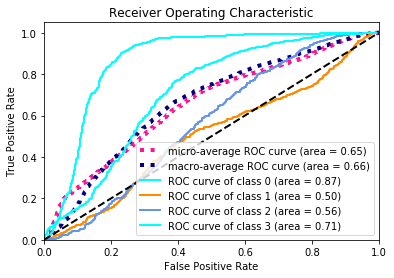

ROC for SVC model without scaling - electricity


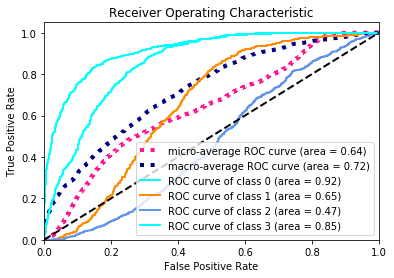

ROC for SVC model with standard scaling - gas


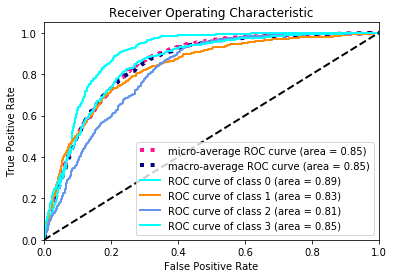

ROC for SVC model with standard scaling - electricity


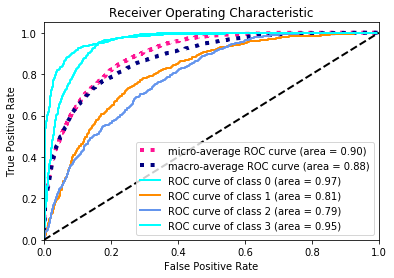

In [97]:
#pipelines for default svc with standard scaling
pipe_svc_g = make_pipeline(IterativeImputer(), 
                                    OneVsRestClassifier(LinearSVC(random_state=0)))
pipe_svc_e = make_pipeline(IterativeImputer(),
                                     OneVsRestClassifier(LinearSVC(random_state=0)))
pipe_svc_g_ss = make_pipeline(StandardScaler(), 
                                    IterativeImputer(), 
                                    OneVsRestClassifier(LinearSVC(random_state=0)))
pipe_svc_e_ss = make_pipeline(StandardScaler(), 
                                     IterativeImputer(),
                                     OneVsRestClassifier(LinearSVC(random_state=0)))

pipe_svc_g.fit(X_train_g, y_train_g)
pipe_svc_e.fit(X_train_e, y_train_e)
pipe_svc_g_ss.fit(X_train_g, y_train_g)
pipe_svc_e_ss.fit(X_train_e, y_train_e)

pipe_svc_g_score = pipe_svc_g.decision_function(X_test_g)
pipe_svc_e_score = pipe_svc_e.decision_function(X_test_e)
pipe_svc_g_ss_score = pipe_svc_g_ss.decision_function(X_test_g)
pipe_svc_e_ss_score = pipe_svc_e_ss.decision_function(X_test_e)

print('ROC for SVC model without scaling - gas')
print_roc(y_test_g, pipe_svc_g_score)
print('ROC for SVC model without scaling - electricity')
print_roc(y_test_e, pipe_svc_e_score)
print('ROC for SVC model with standard scaling - gas')
print_roc(y_test_g, pipe_svc_g_ss_score)
print('ROC for SVC model with standard scaling - electricity')
print_roc(y_test_e, pipe_svc_e_ss_score)

From these ROC curves we can see (just like we have seen above) that model performance increases when the data is scaled. The AUC scores increase ~ 15-20 %.

## ROC - Logistic Regression

/Users/sebastiaanvergunst/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/sebastiaanvergunst/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/sebastiaanvergunst/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/sebastiaanvergunst/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/sebastiaanvergunst/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:929: Con

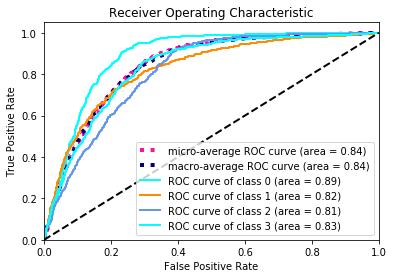

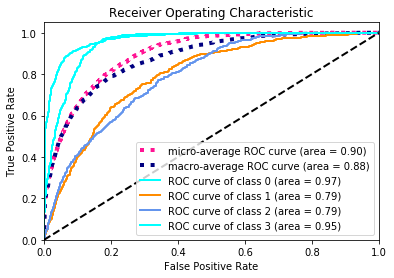

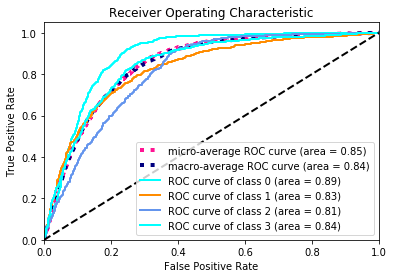

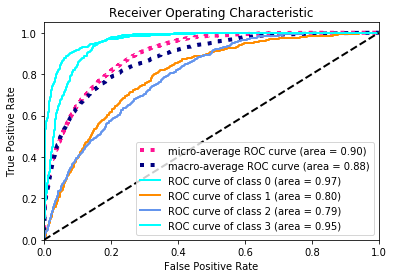

In [91]:
#setup pipeline - includes scaler and imputer
pipe_lr_g = make_pipeline(SimpleImputer(), OneVsRestClassifier(LogisticRegression(random_state=0, C=825)))
pipe_lr_e = make_pipeline(SimpleImputer(), OneVsRestClassifier(LogisticRegression(random_state=0, C=600)))
pipe_lr_ss_g = make_pipeline(StandardScaler(), SimpleImputer(), OneVsRestClassifier(LogisticRegression(random_state=0, C=825)))
pipe_lr_ss_e = make_pipeline(StandardScaler(), SimpleImputer(), OneVsRestClassifier(LogisticRegression(random_state=0, C=300)))

pipe_lr_g.fit(X_train_g, y_train_g)
pipe_lr_e.fit(X_train_e, y_train_e)
pipe_lr_ss_g.fit(X_train_g, y_train_g)
pipe_lr_ss_e.fit(X_train_e, y_train_e)


pipe_lr_g_score = pipe_lr_g.decision_function(X_test_g)
pipe_lr_e_score = pipe_lr_e.decision_function(X_test_e)
pipe_lr_ss_g_score = pipe_lr_ss_g.decision_function(X_test_g)
pipe_lr_ss_e = pipe_lr_ss_e.decision_function(X_test_e)

print('ROC for Logistic Regression model without scaling - gas')
print_roc(y_test_g, pipe_lr_g_score)
print('ROC for Logistic Regression model without scaling - electricity')
print_roc(y_test_e, pipe_lr_e_score)
print('ROC for Logistic Regression model with standard scaling - gas')
print_roc(y_test_g, pipe_lr_ss_g_score)
print('ROC for Logistic Regression model with standard scaling - electricity')
print_roc(y_test_e, pipe_lr_ss_e)


From the ROC curves it can be concluded again that scaling doesn't impact model performance.

## ROC - Decision Tree

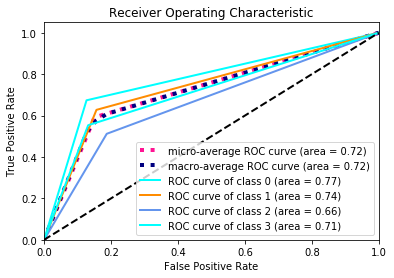

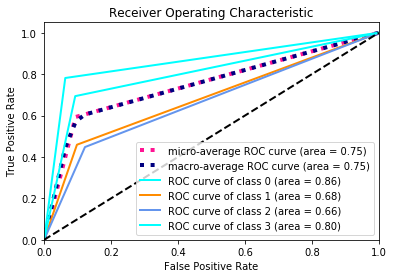

In [36]:
#setting up pipelines
dt_pipeline_g = make_pipeline(SimpleImputer(), OneVsRestClassifier(DecisionTreeClassifier(random_state=0, max_depth=10, min_samples_split=2, min_samples_leaf=12, max_features='sqrt')))
dt_pipeline_e = make_pipeline(SimpleImputer(), OneVsRestClassifier(DecisionTreeClassifier(random_state=0, max_depth=9, min_samples_split=2, min_samples_leaf=11, max_features='log2')))

#fitting data
dt_pipeline_g.fit(X_train_g, y_train_g)
dt_pipeline_e.fit(X_train_e, y_train_e)

dt_pipeline_g_score = dt_pipeline_g.predict(X_test_g)
dt_pipeline_e_score = dt_pipeline_e.predict(X_test_e)

print('ROC for Decision Tree model without scaling - gas')
print_roc(y_test_g, dt_pipeline_g_score)
print('ROC for Decision Tree model without scaling - electricity')
print_roc(y_test_e, dt_pipeline_e_score)

## Conclusion
In our models there is not a big advantage to use ROC over Accuracy, because our classes were balanced.